# Swin Transformers as a special sparsity pattern

In this notebook, we will show how the recently-introduced [Swin Transformers](https://arxiv.org/abs/2103.14030) can be cast
as a sparse transformer with a particular sparsity pattern.


Swin Transformers is a hierarchical Transformer whose representation is computed with shifted windows.
The shifted windowing scheme brings efficiency by limiting self-attention computation to non-overlapping local windows while also allowing for cross-window connection

<img src="https://github.com/microsoft/Swin-Transformer/raw/main/figures/teaser.png" alt="drawing" width="50%"/>


In this notebook, we will cover:
- what type of self-attention is needed to replicate a Swin Transformer
- we will show how one can modify their pre-trained Swin Transformer to use the sparse kernels from xformers instead of hand writing the Swin Transformer self-attention by hand.

Let's start with a few imports. In this notebook, the vanilla Swin Transformer will be taken from `timm`.

In [1]:
import matplotlib.pyplot as plt
import copy
import torch
from torch import nn
from torch.utils import benchmark

import xformers.components.attention.attention_patterns as AP
from xformers.components.attention.core import scaled_dot_product_attention
from xformers.components.attention._sputnik_sparse import SparseCS

import timm

%matplotlib inline

## What sparsity pattern does Swin Transformer correspond to?

In xformers, we provide for reference a default implementation of the attention pattern that corresponds to the Swin Transformer architecture.

It can be found together with the other attention patterns in `xformers.components.attention.attention_patterns`.

Let's try it out on the example case from above, on an image of size 8x8, and windows of size 4:

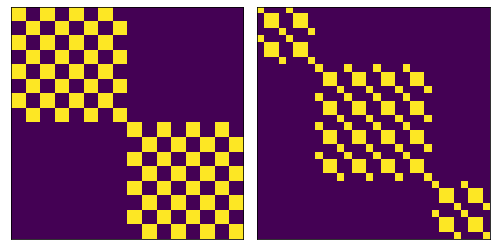

In [2]:
H, W = 8, 8
window_size = 4

mask = AP.swin_attention_pattern(H, W, window_size, shift_size=0)
mask_shifted = AP.swin_attention_pattern(H, W, window_size, shift_size=2)

fig = plt.figure(figsize=(7, 14))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(mask)
plt.xticks([])
plt.yticks([])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(mask_shifted)
plt.xticks([])
plt.yticks([])
fig.tight_layout()
plt.show()

Now let's visualize the self-attention for every pixel in the image. Every sub-image corresponds to the self-attention for one pixel

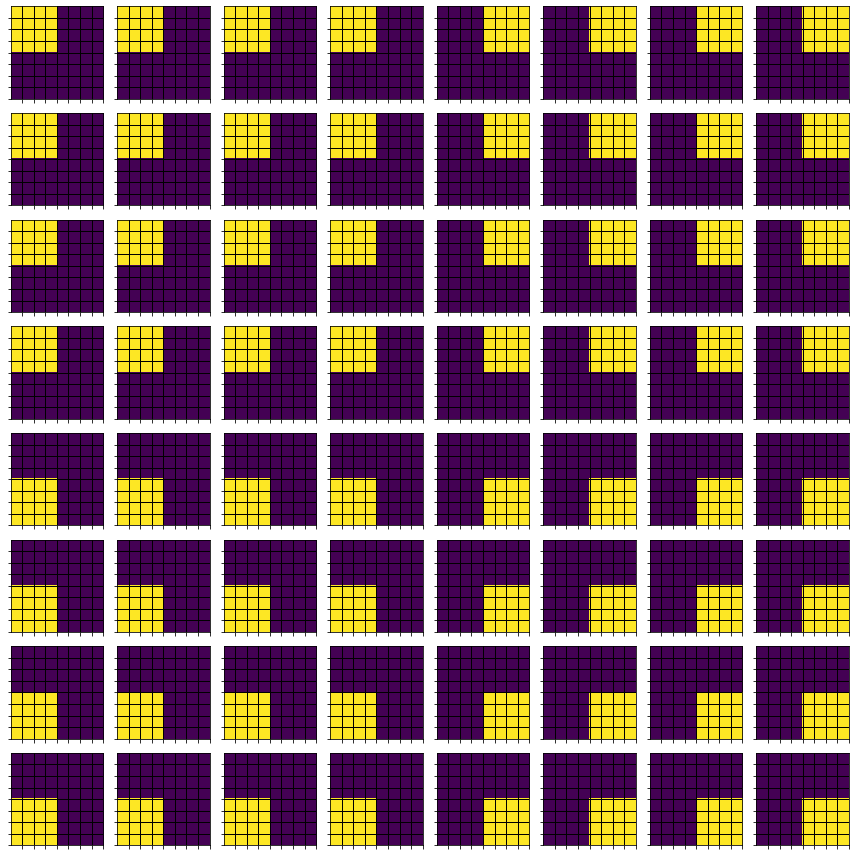

In [3]:
fig = plt.figure(figsize=(12, 12))
for i in range(H * W):
    ax = fig.add_subplot(H, W, i + 1)
    ax.imshow(mask[i].reshape(H, W))
    ax.grid(color='k', linestyle='-', linewidth=1)
    ax.set_xticks(torch.arange(0.5, W))
    ax.set_yticks(torch.arange(0.5, H))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
fig.tight_layout()
plt.show()

And for the shifted case

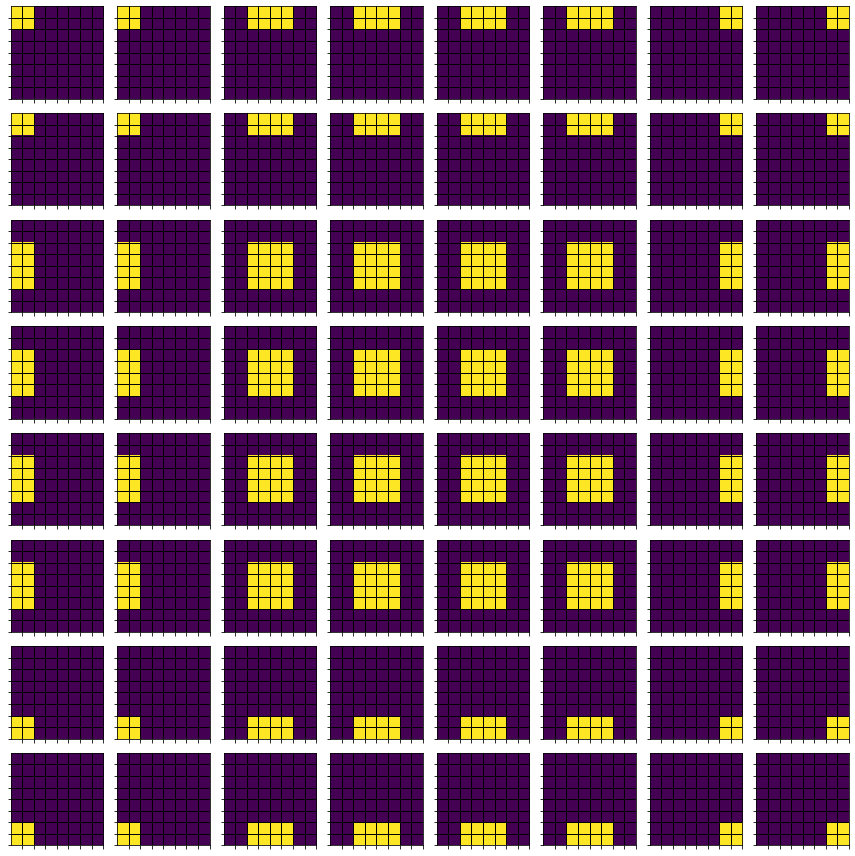

In [4]:
fig = plt.figure(figsize=(12, 12))
for i in range(H * W):
    ax = fig.add_subplot(H, W, i + 1)
    ax.imshow(mask_shifted[i].reshape(H, W))
    ax.grid(color='k', linestyle='-', linewidth=1)
    ax.set_xticks(torch.arange(0.5, W))
    ax.set_yticks(torch.arange(0.5, H))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
fig.tight_layout()
plt.show()

We can see that the self-attention maps correspond to the images in the paper (shown in the top of the notebook), illustrating that indeed a custom sparsity pattern is enough to reproduce Swin Transformer without having to ressort to implementing custom code.

Plus, it is trivial to extend Swin Transformer with other attention patterns (such as local 2d, axial and more, see [the 2d attetnion patterns notebook](https://github.com/fairinternal/xformers/blob/main/docs/source/2d_attention_patterns.ipynb) for more examples.

## Using Swin Transformers as a sparse Transformer in your model

Now that we know that we can represent a Swin Transformer as a particular instantiation of a sparse Transformer, let's use xformers efficient sparse kernels to see
what type of speed / memory trade-offs we get by casting a Swin Transformer as a sparse Transformer.

To facilitate benchmarking and memory profiling, let's define a function that takes a generic callable and executes it, measuring the execution time and the GPU memory

In [5]:
def profile_model(fn, min_run_time=2):
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
    res = benchmark.Timer(
        stmt='fn()',
        globals={"fn": fn},
        label="profile",
        sub_label="",
        description=""
    ).blocked_autorange(min_run_time=min_run_time)
    torch.cuda.synchronize()
    memory = torch.cuda.max_memory_allocated() / 2 ** 20
    memory = f"Memory used: {memory} MB"
    print(res)
    print(memory)

Now it comes the core of it. We will implement an `Attention` module following the same API and modules as timm's, but using our `scaled_dot_product_attention` function.

Note the similarities between this implementation and the one from the [vision transformers notebook](https://github.com/fairinternal/xformers/blob/main/docs/source/vision_transformers.ipynb).

Note that we are not implementing relative positional embedding for simplicity

In [6]:
from timm.models.layers import Mlp, DropPath


# exact the same one as from https://github.com/fairinternal/xformers/blob/main/docs/source/vision_transformers.ipynb
class Attention(torch.nn.Module):
    def __init__(
        self,
        dim,
        num_heads=8,
        qkv_bias=False,
        attn_drop=0.0,
        proj_drop=0.0,
        attn_mask=None,
        **kwargs
    ):
        super().__init__()
        self.num_heads = num_heads

        self.qkv = torch.nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = torch.nn.Dropout(attn_drop)
        self.proj = torch.nn.Linear(dim, dim)
        self.proj_drop = torch.nn.Dropout(proj_drop)
        self.attn_mask = attn_mask

    def forward(self, x):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )

        qkv = qkv.flatten(1, 2)

        q, k, v = qkv.unbind()
        
        x = scaled_dot_product_attention(q, k, v, self.attn_mask, dropout=self.attn_drop)
        
        x = x.reshape(B, self.num_heads, N, C // self.num_heads)

        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
    

# almost copy and paste from timm's implementation, but removing the unneeded elements
# as we don't need to perform the image partitioning anymore
# Note that we call our swin_attention_pattern in the constructor
# to generate the custom sparsity pattern
class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"
        
        # create swin_attention_pattern sparsity pattern
        attn_mask = AP.swin_attention_pattern(input_resolution[0], input_resolution[1], window_size, shift_size=shift_size)
        attn_mask = SparseCS(attn_mask, torch.device("cuda"))

        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
            attn_mask=attn_mask
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)

        # W-MSA/SW-MSA
        x = self.attn(x)  # nW*B, window_size*window_size, C

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

Let's write a function that given a model, will replace all instances of timm.models.swin_transformer.SwinTransformerBlock with our own implementation, which leverages `scaled_dot_product_attention` and `swin_attention_pattern` from xformers



In [7]:
def replace_attn_with_xformers_one(module):
    module_output = module
    if isinstance(module, timm.models.swin_transformer.SwinTransformerBlock):
                
        module_output = SwinTransformerBlock(module.dim, module.input_resolution, module.num_heads, module.window_size, module.shift_size, module.mlp_ratio)
        module_output.drop_path = module.drop_path
        module_output.norm1 = module.norm1
        module_output.norm2 = module.norm2
        module_output.mlp = module.mlp
        
        module_output.attn.qkv = module.attn.qkv
        module_output.attn.attn_drop = module.attn.attn_drop
        module_output.attn.proj = module.attn.proj
        module_output.attn.proj_drop = module.attn.proj_drop
        
        module_output.train(module.training)
    
    else:

        for name, child in module.named_children():
            module_output.add_module(name, replace_attn_with_xformers_one(child))
    del module
    return module_output

Now it's time to create our Swin Transformer. Nothing unusual here. Note that we will be keeping a copy of the model, which will be the model to use sparse self-attention

In [8]:
model = timm.models.create_model("swin_base_patch4_window7_224").cuda().eval()

# zero relative positional embedding in original model as we don't implement it here
for n, p in model.named_parameters():
    if "relative_position_bias_table" in n:
        torch.nn.init.zeros_(p)

model_sparse = copy.deepcopy(model)
model_sparse = replace_attn_with_xformers_one(model_sparse)

Let's new create an input tensor verify if both the sparse and the baseline versions produce the same results

In [9]:
i = torch.rand(32, 3, 224, 224).cuda()

with torch.no_grad():
    r0 = model(i)
    r1 = model_sparse(i)

diff = (r0 - r1).abs()
    
print(f"Median absolute difference: {diff.median().item():.2e}")
print(f"Max absolute difference:    {diff.max().item():.2e}")

Median absolute difference: 3.70e-05
Max absolute difference:    2.51e-04


The results are almost the same. The reason why they are not equivalent up to float precision is because we currently assume that the number of non-zero elements in the sparse matrix is a multiple of 4, so up to 3 elements in the self-attention might be dropped in order to satisfy this constraint.
This constraint will be lifted in the future.

Let's new benchmark both the sparse and the baseline versions

### Profiling the baseline (dense) model

In [10]:
print("Forward only")
with torch.no_grad():
    profile_model(lambda : model(i))
print("")
print("Forward + backward")
profile_model(lambda : model(i).sum().backward())

Forward only
profile
  Median: 212.33 ms
  IQR:    9.49 ms (210.94 to 220.43)
  10 measurements, 1 runs per measurement, 1 thread
Memory used: 1448.72509765625 MB

Forward + backward
profile
  Median: 626.96 ms
  IQR:    12.91 ms (623.15 to 636.06)
  4 measurements, 1 runs per measurement, 1 thread
Memory used: 8615.0703125 MB


### Profiling the sparse model

In [11]:
print("Forward only")
with torch.no_grad():
    profile_model(lambda : model_sparse(i))
print("")
print("Forward + backward")
profile_model(lambda : model_sparse(i).sum().backward())

Forward only
profile
  Median: 208.51 ms
  IQR:    1.29 ms (208.06 to 209.34)
  10 measurements, 1 runs per measurement, 1 thread
Memory used: 1636.5673828125 MB

Forward + backward
profile
  Median: 607.60 ms
  IQR:    9.11 ms (605.09 to 614.20)
  4 measurements, 1 runs per measurement, 1 thread
Memory used: 8770.02001953125 MB


Those results indicate that the sparse model achieves the same speed as the manually-implemented dense version.
This is very encouraging, as with a generic sparse implementation we are able to achieve comparable speed versus the optimized dense implementation, while being substantially simpler to implement (specially on the windows shift optimizations, see [\[1\]](https://github.com/microsoft/Swin-Transformer/issues/52) and [\[2\]](https://github.com/microsoft/Swin-Transformer/issues/38) for examples).

From the memory perspective, the sparse model uses slightly more memory, as it needs to keep the indices of the non-zero elements in memory, while in the baseline dense model the structure is encoded directly in the code. Note that we can further reduce the memory needs by re-using the same sparse pattern over multiple layers.

# Wrapping up

In this notebook, we've shown that Swin Transformers can be casted as a sparse transformer, and we've shown that a generic implementation based on the sparse kernels from `xformers` is able to match performances compared to the hand-crafted implementation.

We hope that this will further illustrate the power of custom sparsity patterns, and we hope xformers will enable new research directions on large sequences.

Do not hesitate to reach out if you have questions.